In [ ]:
!pip install osmnx folium matplotlib mapclassify scikit-learn plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely import wkt
import matplotlib.pyplot as plt
from pyproj import Proj, transform
import seaborn as sns
from shapely.geometry import Point
from geopandas import GeoDataFrame
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
import scipy

## Download list of building and amenity types from Open Street Map (OSM)

In [ ]:
tab_buildings = pd.read_html('https://wiki.openstreetmap.org/wiki/Key:building', match='Value')
tab_amenities = pd.read_html('https://wiki.openstreetmap.org/wiki/Key:amenity', match='Value')

In [ ]:
building_types = tab_buildings[0]
amenity_types = tab_amenities[0]

# Format building types and amenity types to have only one column label per column
building_types.columns = building_types.columns.droplevel(1)
amenity_types.columns = amenity_types.columns.droplevel(1)

## Remove undesired amenity types

In [ ]:
bad_amenities = ['driving_school', 'car_rental', 'car_wash', \
    'vehicle_inspection', 'fuel', 'grit_bin', \
    'motorcycle_parking', 'parking', 'parking_entrance', \
    'parking_space', 'taxi']

In [ ]:
amenity_types = amenity_types[(amenity_types['Key'] == 'amenity') & (~amenity_types['Value'].isin(bad_amenities))]
desired_amenities = list(amenity_types['Value'])
desired_slices = [np.arange(18,25), np.arange(26, 37), np.arange(38, 53), np.arange(69, 72)]
desired_inds = np.concatenate(desired_slices)
desired_types = list(building_types.loc[desired_inds]['Value'])

Modified Silhouette -- Get silhouette scores + cluster densities for each point, where cluster density = cardinality/voronoi cell area

In [ ]:
from sklearn.metrics import silhouette_samples
from scipy.spatial import ConvexHull

def modified_silhouette(cluster_df, cluster_col='Label', lng_dim='Longitude', lat_dim='Latitude'):
  labels = cluster_df[cluster_col].unique()
  scores = []
  if len(labels) < 2:
    return 0.0

  print("Start silhouettes")
  print(cluster_df.columns)
  silhouettes = silhouette_samples(cluster_df[[lng_dim, lat_dim]], cluster_df[cluster_col])
  print("Got Scores")
  cluster_df["Score"] = silhouettes

  for label in labels:
    label_df = cluster_df[cluster_df[cluster_col] == label]
    cardinality = label_df.shape[0]
    voronoi_cell = ConvexHull(label_df[[lng_dim, lat_dim]])
    density = cardinality/voronoi_cell.area
    cluster_silhouette = np.mean(label_df["Score"]) + density
    scores.append(cluster_silhouette)

  return np.sum(scores)

In [ ]:
def entropy(cluster_df, cluster_col='Label', lng_dim='Longitude', lat_dim='Latitude', amen_dim='Amenity'):
  labels = cluster_df[cluster_col].unique()
  sum_of_scores = 0.0
  scores = []

  for label in labels:
    label_df = cluster_df[cluster_df[cluster_col] == label]
    vc = list(label_df[amen_dim].value_counts(normalize=True))
    print(sum(vc))
    entropy = 0.0
    for val in vc:
      entropy -= val * np.log2(val)
    #scaled_card = label_df.shape[0]/cluster_df.shape[0]
    scores.append(entropy)

  print(scores)
  return np.var(scores)

In [ ]:
from pprint import pprint
import math

class ClusteringResult:
  def __init__(self, df, score, n_clusters, centers=None, estimator=None):
    self.df = df
    self.score = score
    self.n_clusters = n_clusters
    self.centers = centers
    self.estimator = estimator

def density_score(cluster_df, cluster_col='Label', lng_dim='Longitude', lat_dim='Latitude'):
  labels = cluster_df[cluster_col].unique()
  sum_of_scores = 0.0
  scores = []

  for label in labels:
    label_df = cluster_df[cluster_df[cluster_col] == label]
    cardinality = label_df.shape[0]

    centroid_lng, centroid_lat = sum(label_df[lng_dim])/cardinality, sum(label_df[lat_dim])/cardinality

    distances = [0.0] * cardinality
    for idx, lng in enumerate(list(label_df[lng_dim])):
      distances[idx] += (lng - centroid_lng) ** 2
    for idx, lat in enumerate(list(label_df[lat_dim])):
      distances[idx] += (lat - centroid_lat) ** 2

    scores.append(cardinality/np.var(distances))
    sum_of_scores += cardinality/np.var(distances)

  return np.var(scores)

def cluster_facilities(center_lat, center_lng, dist, max_k, desired_types, desired_amenities, score_func, clustering, use_type=False, min_k=1):
  center_point = (center_lat, center_lng)
  tags = {'building': desired_types, 'amenity': desired_amenities}
  G = ox.geometries_from_point(center_point, tags, dist=dist)

  #assemble dataset of points
  X = []
  for p in list(G.geometry.node):
    X.append([p.x, p.y])
  X = np.array(X)
  X_df = pd.DataFrame(X, columns=['Longitude', 'Latitude'])
  if use_type:
    X_df['Amenity'] = list(G.amenity.node)
  num_datapoints = X_df.shape[0]
  print(f'Training Data Points: {num_datapoints}')

  result = []

  if max_k > 0:
    for k in range(min_k, max_k + 1):
      #km = KMeans(n_clusters=k)
      #km.fit(X_df)
      #labels = km.labels_

      cl = clustering(n_clusters=k)
      print(f"FITTING {k}")
      cl.fit(X_df[['Longitude', 'Latitude']])
      print("FITTING DONE")
      labels = cl.labels_

      X_df['Label'] = labels

      print("SCORING")
      score = score_func(X_df)
      print("SCORING DONE")

      result.append(ClusteringResult(X_df.copy(), score, k, estimator=cl, centers=cl.cluster_centers_))
      print(f"FINISHED {k} CLUSTERS, score {score}")

      result.sort(key=lambda x : x.score)
  else:
    cl = clustering()
    print("FITTING")
    res = cl.fit(X_df[['Longitude', 'Latitude']])
    print("FITTING DONE")
    labels = cl.labels_

    X_df['Label'] = labels
    score = score_func(X_df)
    result.append(ClusteringResult(X_df.copy(), score, len(labels), centers=res.cluster_centers_))

  return result

In [ ]:
#BOSTON: 42.319821, -71.079803
#LA: 34.0549, -118.2426
result = cluster_facilities(34.0549, -118.2426, 20000, 50, desired_types, desired_amenities, entropy, KMeans, True, min_k=1)

<ipython-input-9-05cca5541124>:37: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  G = ox.geometries_from_point(center_point, tags, dist=dist)


Training Data Points: 11951
FITTING 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000007
[4.374078221043508]
SCORING DONE
FINISHED 1 CLUSTERS, score 0.0
FITTING 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0
0.999999999999999
[4.443604735440825, 4.182072707433543]
SCORING DONE
FINISHED 2 CLUSTERS, score 0.017099750418400513
FITTING 3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999999
0.9999999999999997
0.9999999999999996
[4.245793642763406, 4.030476711431278, 4.516468747126868]
SCORING DONE
FINISHED 3 CLUSTERS, score 0.039534961311111
FITTING 4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000007
1.0
0.9999999999999991
1.0000000000000004
[4.164415811964666, 4.1682522097627235, 4.0706432104372094, 4.538381124769015]
SCORING DONE
FINISHED 4 CLUSTERS, score 0.03212248505641729
FITTING 5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000004
0.9999999999999999
[4.2291063074934545, 4.159050124098807, 4.502680939284608, 3.4869766930085846, 4.371846901841669]
SCORING DONE
FINISHED 5 CLUSTERS, score 0.12390789760957163
FITTING 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0
0.9999999999999996
0.9999999999999994
0.9999999999999993
0.9999999999999997
1.0000000000000004
[4.168875182496482, 4.155021017362458, 4.328008540818507, 4.428673599743332, 3.479006015356655, 4.298066294637975]
SCORING DONE
FINISHED 6 CLUSTERS, score 0.0969308571213673
FITTING 7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999996
0.9999999999999999
0.9999999999999997
1.0000000000000007
0.9999999999999996
1.0000000000000002
0.9999999999999996
[4.272278706921158, 4.108224898560275, 4.171491434164799, 4.304560362015371, 4.437122188970966, 4.204393936317567, 3.3782380292876013]
SCORING DONE
FINISHED 7 CLUSTERS, score 0.10253609321166945
FITTING 8


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999996
0.9999999999999999
0.9999999999999994
0.9999999999999999
0.9999999999999997
1.0000000000000004
0.9999999999999998
1.0000000000000002
[4.010009426163109, 4.091352383147955, 4.223605494844492, 4.324880031187213, 4.226770518119685, 4.430467579124549, 3.3812244137352456, 4.287641491599997]
SCORING DONE
FINISHED 8 CLUSTERS, score 0.0934099787714418
FITTING 9


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999994
1.0000000000000004
1.0
1.0000000000000007
1.0
1.0000000000000007
0.9999999999999997
0.9999999999999993
1.0000000000000002
[4.041177745655396, 4.089876836728836, 4.231553115155256, 4.407828496272486, 4.223963952018232, 4.4166969526796604, 3.602456848811575, 4.291119610651889, 2.960426439727625]
SCORING DONE
FINISHED 9 CLUSTERS, score 0.1965784762824151
FITTING 10


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
0.9999999999999997
1.0
0.9999999999999992
1.0
1.0000000000000007
0.9999999999999997
0.9999999999999993
0.9999999999999997
0.9999999999999997
[4.033769762178318, 4.135487848294458, 4.214921215474768, 4.405733638937271, 4.25231984785786, 4.415868318973612, 3.9377584447784884, 3.5898811555219075, 4.256131271569128, 2.9599395336182135]
SCORING DONE
FINISHED 10 CLUSTERS, score 0.17822477431730444
FITTING 11


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999994
1.0000000000000002
0.9999999999999994
1.0000000000000002
0.9999999999999999
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999997
0.9999999999999999
1.0000000000000002
[3.973289116106826, 4.138390759644355, 4.240168256202172, 4.42255058980058, 4.251188745616382, 4.495601863261053, 4.316877135730685, 3.9358027404127007, 3.5988670590077154, 4.249718004329291, 2.9414191131102565]
SCORING DONE
FINISHED 11 CLUSTERS, score 0.18039091294911477
FITTING 12


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
1.0000000000000004
0.9999999999999993
0.9999999999999994
0.9999999999999999
1.0000000000000007
1.0
0.9999999999999991
0.9999999999999998
1.0000000000000002
0.9999999999999997
1.0000000000000002
[3.984573221970876, 3.797059649859078, 4.218195364107022, 4.427300697714942, 4.2211934541844665, 4.4860654319257645, 4.312074512696294, 3.9777284357692935, 3.582554947673018, 4.199797174275298, 2.929201120075144, 4.253124153291382]
SCORING DONE
FINISHED 12 CLUSTERS, score 0.1722458641766689
FITTING 13


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
0.9999999999999997
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0
1.0000000000000007
0.9999999999999996
0.9999999999999998
1.0000000000000004
0.9999999999999997
[3.941795451790399, 3.82410925267649, 4.238941610485177, 4.420330022595523, 4.20350539005346, 4.475234765759323, 4.13285524027222, 3.979062688150752, 3.5689217226334677, 4.26178045916008, 4.277384830331062, 4.164600555774077, 2.933032058029733]
SCORING DONE
FINISHED 13 CLUSTERS, score 0.15666085324135698
FITTING 14


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
0.9999999999999996
1.0000000000000007
0.9999999999999998
0.9999999999999997
1.0000000000000004
1.0
0.9999999999999992
1.0
0.9999999999999998
1.0000000000000002
0.9999999999999996
1.0000000000000004
1.0
[3.936117728976859, 3.8129753879345425, 4.2392191596064315, 4.368436282902824, 4.223115293634279, 4.466797641712424, 4.121295794698911, 3.980781607518659, 3.481741244990487, 3.1298957704140684, 4.2520703160052244, 4.19373711934558, 3.39524625591451, 4.258249855125549]
SCORING DONE
FINISHED 14 CLUSTERS, score 0.14803953025281028
FITTING 15


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000007
1.0
0.9999999999999996
0.9999999999999998
0.9999999999999988
0.9999999999999994
0.9999999999999998
0.9999999999999996
1.0
0.9999999999999998
0.9999999999999994
1.0000000000000004
1.0000000000000007
1.0000000000000004
0.9999999999999992
[3.9325931383411197, 3.812590522144762, 4.236414441992997, 4.368436282902824, 4.24497855478628, 4.46620526014089, 4.128370881804255, 3.965061891683757, 3.481741244990487, 3.1298957704140684, 4.148377583638179, 4.249534931186304, 4.2876119703794, 3.39524625591451, 4.030842809652853]
SCORING DONE
FINISHED 15 CLUSTERS, score 0.13898179433943503
FITTING 16


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999997
1.0
0.9999999999999999
1.0000000000000004
0.9999999999999998
1.0000000000000007
0.9999999999999998
0.9999999999999993
0.9999999999999999
0.9999999999999998
0.9999999999999994
1.0000000000000002
0.9999999999999999
0.9999999999999999
1.0000000000000009
1.0000000000000002
[3.929014610874218, 3.8094320874680445, 4.224767764103694, 4.363654972927693, 4.239889310132951, 4.467492281201487, 4.137687580060559, 3.9745908040021014, 3.4829667413057948, 3.1231157374225353, 4.143168386996824, 4.2446487181209545, 4.2891876436342855, 3.9839020707117823, 3.414271170592072, 4.058862680138033]
SCORING DONE
FINISHED 16 CLUSTERS, score 0.12912801696323517
FITTING 17


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999996
1.0000000000000004
0.9999999999999991
0.9999999999999994
1.0
1.0000000000000004
1.0
0.9999999999999993
0.9999999999999999
0.9999999999999999
0.9999999999999994
0.9999999999999994
0.9999999999999997
1.0000000000000004
0.9999999999999996
0.9999999999999999
1.0000000000000002
[4.011168727827468, 3.8249911736356963, 4.154043789980042, 4.305272371215773, 4.227375392791731, 4.456262221281376, 4.091737045738334, 3.973940938941306, 3.4829667413057948, 3.1253645938962054, 4.148408721882764, 4.249653987579336, 4.277296253791813, 3.968867509888571, 4.056718617661539, 3.573132731356976, 4.039997654593482]
SCORING DONE
FINISHED 17 CLUSTERS, score 0.105772791932281
FITTING 18


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0
0.9999999999999994
0.9999999999999997
1.0
1.0
0.9999999999999994
0.9999999999999996
0.9999999999999994
1.0
1.0000000000000004
0.9999999999999997
0.9999999999999997
1.0
1.0000000000000007
0.9999999999999996
0.9999999999999999
1.0000000000000002
1.0
[3.995085728662247, 3.7971934526566873, 4.140928138951198, 4.29986907571233, 4.227375392791731, 4.457624156208299, 4.087870448071564, 3.9890315551299427, 3.4694553221258566, 2.6846006022819946, 4.25195292726093, 4.277296253791813, 4.159801588843897, 3.9639555696024265, 4.073500614285328, 3.5385656475108176, 4.039997654593482, 3.4686721096027537]
SCORING DONE
FINISHED 18 CLUSTERS, score 0.16870145221578947
FITTING 19


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999997
0.9999999999999999
0.9999999999999994
0.9999999999999994
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999998
0.9999999999999993
0.9999999999999994
1.0000000000000004
0.9999999999999999
1.0000000000000002
0.9999999999999999
1.0000000000000004
1.0000000000000002
[3.914564333620955, 3.7708743989754874, 3.9046099944381436, 4.307371018778129, 4.256053741256894, 4.443129542183465, 4.076479347908786, 4.3950937579768645, 3.9791229297361195, 3.506823338978401, 4.1444100067619125, 4.230582971006081, 4.264485698563741, 4.03939208485953, 3.491660929919915, 4.034532519456863, 4.205168335431202, 2.8524255172173683, 3.4660925439169437]
SCORING DONE
FINISHED 19 CLUSTERS, score 0.15016043853487038
FITTING 20


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999994
1.0000000000000004
1.0000000000000004
1.0000000000000007
0.9999999999999998
0.9999999999999996
1.0
0.9999999999999997
0.9999999999999994
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000009
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999994
1.0000000000000002
[4.0034858948299625, 3.7787600945217013, 4.136926678109124, 4.273899523785528, 4.227881884553658, 4.40767061618982, 4.0590682882435365, 4.382999987035637, 3.9890315551299427, 3.5502674985921243, 4.234347250443908, 4.282644033884614, 4.169143903904308, 3.9599184837417845, 4.072845565489726, 3.6886839202473416, 4.056656601214055, 2.476986617821847, 3.126357032370972, 3.485366267376437]
SCORING DONE
FINISHED 20 CLUSTERS, score 0.20987702901968674
FITTING 21


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999998
1.0000000000000007
0.9999999999999996
1.0
1.0000000000000004
1.0000000000000004
1.0
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999997
0.9999999999999994
1.0000000000000002
1.0
1.0000000000000004
0.9999999999999997
0.9999999999999998
0.9999999999999994
0.9999999999999996
0.9999999999999996
1.0
[3.951292626650567, 3.486194052060035, 4.122595001828702, 4.269386886250034, 4.214770012387711, 3.658608957312165, 4.415640162759089, 4.067913383671728, 4.373329008676122, 3.94324694661482, 3.510069759458135, 4.237386033780147, 4.243572935548122, 4.150839357704839, 3.979320256714845, 4.006965281966089, 3.736588993685645, 3.8769720042584797, 2.8798295343164937, 3.4250311743248116, 4.202170353785981]
SCORING DONE
FINISHED 21 CLUSTERS, score 0.13581484518173398
FITTING 22


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000007
0.9999999999999996
0.9999999999999996
0.9999999999999993
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999996
0.9999999999999994
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000007
1.0000000000000009
0.9999999999999997
0.9999999999999999
0.9999999999999994
0.9999999999999999
0.9999999999999994
1.0000000000000007
1.0000000000000009
[3.890270310255004, 3.811408093637347, 4.141727946108495, 4.337768252411713, 4.2161954252358935, 4.399793405779444, 4.146935361076892, 4.379968958074879, 3.4414829985248625, 3.467050730311849, 3.971884127653632, 4.2263533425788795, 4.240148048185271, 3.860840927843464, 3.9606023889190465, 3.2402083677409377, 4.072502427398891, 4.187307618483817, 3.0049487880128445, 3.3990730669591085, 3.8516351732163496, 4.145911154809484]
SCORING DONE
FINISHED 22 CLUSTERS, score 0.14435659912369272
FITTING 23


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999997
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999998
0.9999999999999999
1.0
1.0
0.9999999999999996
1.0000000000000002
0.9999999999999998
0.9999999999999993
1.0000000000000002
0.9999999999999996
0.9999999999999998
1.0000000000000004
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999997
0.9999999999999998
0.9999999999999994
1.0000000000000007
[3.914880817634115, 3.8663482436779693, 4.140884955627392, 4.128207666911683, 4.227307539346364, 4.380969760232938, 4.100698859848166, 4.38824699293491, 3.455731773342323, 3.492679187366029, 3.922914215647126, 4.322880163429407, 4.203595959976474, 4.287817449539644, 3.8716096552446673, 3.9806863944680013, 3.990024289516055, 2.0456467784453856, 4.021648847524402, 3.3799071802772054, 3.4104967421326466, 3.4122471432904344, 4.14329610271776]
SCORING DONE
FINISHED 23 CLUSTERS, score 0.25102610847774903
FITTING 24


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0
1.0000000000000004
0.9999999999999997
0.9999999999999993
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000004
0.9999999999999997
0.9999999999999997
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999997
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000007
0.9999999999999994
0.9999999999999999
0.9999999999999997
1.0
[3.9047876830371995, 3.469730414937867, 4.140318978459789, 4.280528646961708, 4.214770012387711, 3.7047164764973326, 4.401749181482455, 4.146412443245577, 4.364341022847216, 3.4198595933724207, 3.7632153330092777, 3.514398518716988, 3.925759936812588, 4.2219605441299475, 4.221586726370517, 3.856157421954694, 4.122233028005568, 3.953788335757631, 3.9618574770272588, 3.106619107348094, 3.8831178788780596, 3.0544910974490684, 3.4163873114107886, 4.208090286444412]
SCORING DONE
FINISHED 24 CLUSTERS, score 0.14105131112681954
FITTING 25


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999992
0.9999999999999998
0.9999999999999996
0.9999999999999996
1.0000000000000004
1.0000000000000004
0.9999999999999989
1.0000000000000002
0.9999999999999994
1.0
1.0000000000000007
0.9999999999999997
0.9999999999999999
1.0
1.0000000000000004
0.9999999999999994
1.0000000000000007
0.9999999999999993
1.0000000000000002
1.0
0.9999999999999994
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000007
[3.926100680664373, 3.6763041836070585, 4.132424431143938, 4.323377181337246, 4.214770012387711, 3.7011026258402198, 4.419579328553466, 4.151217843119506, 4.365925357300645, 3.4415593725997753, 3.954174934176679, 3.510344420642165, 3.9460365406327647, 4.2226760760905755, 4.235654140968367, 3.842124019533661, 4.101131678149071, 3.9484225038614023, 3.9655973378070026, 2.633857063268235, 4.187307618483817, 2.981272374018369, 3.4554768362967114, 3.0030029650547605, 3.8516351732163496]
SCORING DONE
FINISHED 25 CLUSTERS, score 0.20291260127569186
FI

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999996
1.0000000000000002
0.9999999999999996
1.0000000000000004
0.9999999999999996
1.0000000000000002
0.9999999999999996
1.0000000000000002
1.0000000000000002
0.9999999999999997
0.9999999999999998
1.0
1.0
0.9999999999999996
1.0000000000000004
0.9999999999999997
0.9999999999999991
0.9999999999999997
0.9999999999999987
1.0
0.9999999999999998
0.9999999999999998
1.0000000000000009
0.9999999999999997
1.0000000000000007
0.9999999999999998
[3.923308213053171, 3.420445631080593, 3.819608770489399, 4.319526833526554, 4.214330842402143, 3.6098190021279617, 4.452346492806802, 4.114419138537539, 4.349994861574194, 3.4229281232986883, 3.9349492272486115, 3.238133497536999, 3.9438080193457536, 4.208913695650001, 4.222545319222274, 3.8436283209941053, 4.124967992344361, 3.6212431834436316, 3.9431183888504333, 4.193652597948841, 2.569468484659873, 3.267804222777952, 4.135565052334795, 3.429350250988094, 3.8516351732163496, 3.89960773982404]
SCORING DONE
FINISHED 26 CLU

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999998
0.9999999999999992
0.9999999999999996
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999997
1.0000000000000004
0.9999999999999996
0.9999999999999999
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999997
0.9999999999999997
1.0000000000000004
0.9999999999999999
1.0000000000000002
1.0000000000000007
1.0
0.9999999999999992
0.9999999999999999
0.9999999999999997
0.9999999999999993
1.0000000000000002
[3.906370412902706, 3.436944332785947, 3.8192077057962783, 4.288526432359526, 4.198881143866557, 3.6949096528904777, 4.436699609290658, 4.120716909364369, 4.360836199720668, 3.3820393250591962, 3.9694769154799667, 3.504775631264141, 3.939420021948934, 4.222618831461789, 4.255807464827723, 3.84462211090052, 4.122401704471333, 3.9498599361214937, 3.5546127516530754, 4.0012403943176915, 4.010154884890523, 2.793673595776286, 2.477204137172587, 3.2670440779548824, 4.113016400959141

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000009
0.9999999999999996
0.9999999999999998
1.0
0.9999999999999996
0.9999999999999993
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999996
1.0000000000000004
1.0000000000000002
1.0000000000000007
0.9999999999999999
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999998
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000007
0.9999999999999998
[3.8880313874187653, 3.43504173393245, 3.80157079066657, 4.074527350429694, 4.214330842402143, 3.724504081765109, 4.395299850718776, 4.1010197077876205, 4.354948795355548, 3.95459158057432, 3.970649505047956, 3.4039674200973473, 4.237643751905137, 4.208913695650001, 4.217932430641686, 3.853162251080817, 4.145393122879754, 3.5373338432187236, 3.96410781635437, 4.197665561092456, 2.851943285868329, 2.4779275515026087, 3.333277371945293, 4.12597744871909, 3.3435549317713678, 3.0177140278510

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000013
0.9999999999999993
0.9999999999999993
1.0
0.9999999999999996
1.0000000000000002
0.9999999999999996
1.0000000000000002
0.9999999999999996
0.9999999999999996
0.9999999999999996
0.9999999999999993
0.9999999999999998
1.0000000000000002
0.9999999999999997
0.9999999999999999
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999998
0.9999999999999994
1.0
0.9999999999999998
0.9999999999999996
0.9999999999999993
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999999
[3.910114037837983, 3.4311725228109995, 3.8084766595943913, 4.2954684410260136, 4.214330842402143, 3.6949096528904777, 4.300963922276966, 4.321253422241111, 4.040928692795689, 4.370636197290553, 3.3820393250591962, 3.969807585380598, 3.379286218795617, 3.939420021948934, 4.160489947764881, 4.247793247019217, 3.8590345000092157, 4.1224413825818615, 3.5496210737490945, 3.9921199120450415, 3.8769720042584797, 2.8356205276364777, 2.484771197861868, 3.3268283482452965, 4.11

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000007
1.0000000000000002
0.9999999999999993
0.9999999999999997
0.9999999999999996
1.0000000000000002
0.9999999999999993
1.0
1.0
0.9999999999999996
0.9999999999999993
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000007
0.9999999999999989
1.0000000000000002
0.9999999999999997
1.0000000000000004
1.0000000000000009
1.0
1.0
0.9999999999999999
0.9999999999999996
1.0000000000000002
0.9999999999999997
1.0000000000000002
1.0000000000000007
0.9999999999999998
0.9999999999999998
[3.9061852136647226, 3.4336901915921225, 3.8084766595943913, 4.075187850648038, 4.214330842402143, 3.6949096528904777, 4.3945446853052, 4.058974575535699, 4.344670929858477, 3.3820393250591962, 3.9712154709035774, 3.3943613257612917, 3.939420021948934, 4.302452296327495, 4.041566430024804, 4.217729099928896, 3.861063955111639, 4.122401704471333, 3.554345275944846, 3.9885994526845074, 4.197831852452176, 2.8345123138954174, 2.4825143914974013, 3.3268283482452965, 4.1217900648120915

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999999
0.9999999999999993
0.9999999999999993
1.0
0.9999999999999996
1.0000000000000002
1.0
0.9999999999999997
1.0
0.9999999999999996
1.0000000000000002
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000007
0.9999999999999994
1.0000000000000007
1.0
1.0000000000000004
0.9999999999999998
1.0
1.0000000000000004
0.9999999999999997
0.9999999999999996
0.9999999999999998
0.9999999999999993
0.9999999999999993
1.0000000000000002
1.0000000000000007
0.9999999999999998
1.0000000000000004
[3.9093444706369116, 3.4311725228109995, 3.8084766595943913, 4.099555036161716, 4.214330842402143, 3.6949096528904777, 4.3672083197959815, 4.053428514768342, 4.330576843230759, 3.3820393250591962, 3.873179911848798, 3.5124142886825127, 3.939420021948934, 4.237643751905137, 4.043576826971641, 4.2218228157361555, 3.802640891638755, 4.1224413825818615, 3.554891852024523, 3.9415448971437725, 4.185940178532849, 2.8223911447536354, 2.4626785908339386, 3.2316384298119

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999992
0.9999999999999997
1.0000000000000007
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999999
0.9999999999999996
0.9999999999999996
0.9999999999999998
0.9999999999999999
1.0000000000000002
0.9999999999999996
0.9999999999999999
0.9999999999999997
0.9999999999999999
0.9999999999999999
1.0000000000000002
0.9999999999999994
0.9999999999999999
0.9999999999999998
0.9999999999999996
1.0000000000000002
0.9999999999999996
0.9999999999999993
1.0000000000000002
0.9999999999999996
0.9999999999999993
0.9999999999999996
1.0
[3.8784852696654233, 3.437495988073927, 3.7907964143036237, 4.0787659290913485, 4.048929984343235, 3.696802485246467, 4.386982433183967, 4.0626992179051555, 4.351019132821301, 3.3820393250591962, 4.0001405152278755, 3.520061532116346, 3.938055756919995, 4.302452296327495, 4.208913695650001, 4.247146168300317, 3.8033943882949126, 3.978673340003545, 3.568408112246617, 3.921722514212525

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999996
1.0000000000000002
0.9999999999999997
1.0
0.9999999999999997
1.0000000000000002
0.9999999999999993
0.9999999999999997
0.9999999999999999
0.9999999999999994
1.0
0.9999999999999998
0.9999999999999994
0.9999999999999998
1.0000000000000002
1.0000000000000007
0.9999999999999996
1.0000000000000002
1.0
0.9999999999999998
0.9999999999999994
1.0
0.9999999999999998
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999994
1.0
1.0
0.9999999999999994
1.0
[3.8917318967780354, 3.432591108649279, 3.8076765423045686, 4.074527350429694, 4.1162789462571965, 3.6949096528904777, 4.397857451818632, 4.082071017368036, 4.326237631975172, 3.3825958460204544, 3.97031691032269, 3.379286218795617, 3.8556950921461257, 4.115686513508994, 4.237643751905137, 4.031730793422524, 4.2111142598325975, 3.8178237651506266, 4.021377006642142, 3.5438847172217454, 3.584816098355121, 3.5976584314139766, 2.8123427893744726, 2.508832039123319, 3.333277371945293, 4

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999991
0.9999999999999993
1.0000000000000004
1.0000000000000002
0.9999999999999996
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999996
1.0
1.0
1.0000000000000002
0.9999999999999998
0.9999999999999994
0.9999999999999996
1.0
0.9999999999999998
0.9999999999999996
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999993
0.9999999999999994
0.9999999999999999
1.0
0.9999999999999998
[3.9475013527718863, 3.4311725228109995, 3.80970983207379, 4.307171071727884, 4.214330842402143, 3.6108275501652094, 4.355573741016176, 4.326771802933508, 4.0635950284843085, 4.306512700877634, 3.3820393250591962, 3.984493206470523, 3.4577476689835116, 3.939420021948934, 4.1483111686807606, 4.21304680132623, 3.810860542201827, 4.1224413825818615, 3.6166142501900493, 3.9026599339792782, 3.4818190084483023,

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
1.0000000000000002
0.9999999999999994
0.9999999999999997
0.9999999999999997
0.9999999999999996
1.0
1.0000000000000009
1.0
1.0000000000000002
0.9999999999999993
1.0
0.9999999999999997
0.9999999999999998
1.0000000000000002
0.9999999999999993
0.999999999999999
0.9999999999999996
0.9999999999999997
0.9999999999999998
0.9999999999999996
0.9999999999999994
0.9999999999999996
0.9999999999999994
0.9999999999999999
0.9999999999999997
1.0
0.9999999999999997
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999998
0.9999999999999997
1.0000000000000004
0.9999999999999998
[3.887503692895401, 3.5671601144677845, 4.150323922530964, 4.0787659290913485, 4.1162789462571965, 3.6933797360011154, 4.3672083197959815, 4.052860933377922, 4.334511692657063, 3.2511421432539978, 3.9785388906355745, 3.389265665813818, 3.7920722194213496, 3.8878715727974917, 4.237643751905137, 4.046805719012731, 4.209630547041392, 3.8026903054285963, 4.110161267744822, 3.5438847172217454

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
0.9999999999999997
1.0000000000000002
1.0000000000000004
0.9999999999999997
1.0
0.9999999999999991
0.9999999999999997
1.0000000000000002
0.9999999999999994
0.9999999999999997
1.0
0.9999999999999994
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999996
0.9999999999999994
0.9999999999999998
1.0
0.9999999999999991
1.0
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999998
0.9999999999999996
1.0000000000000002
0.9999999999999993
1.0
0.9999999999999994
1.0000000000000004
0.9999999999999997
1.0
0.9999999999999998
0.9999999999999998
[3.874020724723264, 3.3593421906834524, 3.3888701846371236, 4.107859377386151, 4.1162789462571965, 3.8196194737261915, 4.368296003798864, 4.053010956635786, 4.326602418680615, 3.3828442869794157, 3.9055691939599724, 2.8334632474363706, 3.9285744025820075, 3.953270240375559, 4.302452296327495, 4.042486301033416, 4.2111142598325975, 3.8185398400585884, 4.164632178617013, 3.609825161412236, 3.808175364847587, 3.597

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
0.9999999999999996
1.0000000000000004
0.9999999999999997
0.9999999999999996
1.0000000000000004
1.0
1.0000000000000007
0.9999999999999998
0.9999999999999996
0.9999999999999998
0.9999999999999999
0.9999999999999997
0.9999999999999994
0.9999999999999993
0.9999999999999996
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999999
1.0000000000000004
0.9999999999999996
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999999
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000007
0.9999999999999998
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000004
[3.8883884873192502, 3.4301457364449894, 4.164705269896699, 4.0787659290913485, 4.214330842402143, 3.396544600164082, 4.3672083197959815, 4.03570185432319, 4.328116574621273, 3.3820393250591962, 3.9948748548078985, 2.783048755796869, 3.9465796854449193, 4.310151664887324, 4.046805719012731, 4.216775441844336, 3.7942525187069176, 4.080627646603272, 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000007
0.9999999999999998
0.9999999999999996
0.9999999999999999
0.9999999999999991
0.9999999999999996
0.9999999999999991
1.0000000000000004
1.0
0.9999999999999998
0.9999999999999996
0.9999999999999999
1.0
1.0000000000000002
0.9999999999999994
1.0000000000000004
0.9999999999999996
0.9999999999999992
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999998
0.9999999999999994
0.9999999999999999
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000004
0.9999999999999996
[3.888580825272262, 3.4144641978940746, 4.432813428333971, 4.103645033567324, 4.053223008359656, 3.6570549198964817, 4.368296003798864, 4.014673927031384, 4.349616929347375, 3.2754978872554217, 3.633245391503337, 2.9806612349654604, 3.9570135682776666, 4.302452296327495, 4.060007246306647, 4.2405195931520305, 3.8176

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
0.9999999999999992
1.0000000000000004
0.9999999999999999
0.9999999999999996
0.9999999999999998
1.0000000000000002
1.0000000000000004
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0000000000000007
1.0000000000000002
0.9999999999999998
0.9999999999999998
1.0000000000000004
1.0000000000000002
0.9999999999999993
0.9999999999999996
1.0000000000000002
0.9999999999999996
1.0000000000000007
1.0
1.0
1.0000000000000002
1.0
0.9999999999999998
1.0000000000000007
1.0000000000000004
0.9999999999999996
1.0000000000000002
1.0000000000000002
0.9999999999999996
1.0
0.9999999999999997
0.9999999999999993
1.0000000000000002
0.9999999999999999
0.9999999999999999
[3.8933557251357818, 3.4200446355101315, 4.077415753061862, 4.3004328693785885, 4.214330842402143, 3.6817654098933024, 4.29066781363824, 4.338186117791588, 4.01754011654997, 4.31833756649599, 3.3808077300702637, 3.6648213280108517, 2.6518937116787797, 3.7733923112229126, 3.8481000854518945, 4.0294

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999998
0.9999999999999994
1.0000000000000007
1.0000000000000004
0.9999999999999996
1.0000000000000002
0.9999999999999991
1.0
0.9999999999999993
0.9999999999999997
0.999999999999999
1.0000000000000002
0.9999999999999998
0.9999999999999996
1.0000000000000004
0.9999999999999996
0.9999999999999996
0.9999999999999999
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0
1.0000000000000002
0.9999999999999997
0.9999999999999998
1.0000000000000002
0.9999999999999998
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0000000000000002
0.9999999999999994
1.0
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
[3.8790425056248057, 3.4056939574828964, 3.796842619706392, 4.107859377386151, 4.111863197399692, 3.666115869229829, 4.368040487558579, 3.8076429373937337, 4.2856944970734565, 3.2736073048684706, 3.9208739453047463, 2.7974125671198706, 3.81301213539028, 3.7863062286779425, 4.3206

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
0.9999999999999998
0.9999999999999998
1.0000000000000002
0.9999999999999997
1.0000000000000004
1.0000000000000007
1.0000000000000002
1.0000000000000004
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999996
1.0
1.0
0.9999999999999997
1.0
0.9999999999999998
1.0000000000000004
0.9999999999999999
1.0000000000000002
1.0
1.0
0.9999999999999998
1.0000000000000007
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999994
1.0000000000000007
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
[3.8683677048223934, 4.02428421922446, 4.08807879580779, 4.069497216536721, 4.1162789462571965, 3.4981700958000674, 4.237557416125429, 4.266288678122109, 3.7351774785615013, 4.245820736775346, 3.164374960970843, 3.471719677185266, 3.5545507801409806, 2.731803612244874, 3.866

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999993
0.9999999999999998
0.9999999999999994
0.9999999999999993
0.9999999999999994
0.9999999999999996
0.9999999999999999
1.0000000000000004
1.0000000000000002
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.9999999999999994
0.9999999999999996
0.9999999999999996
1.0000000000000002
0.9999999999999997
1.0000000000000004
1.0
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0
0.9999999999999996
1.0000000000000004
0.9999999999999993
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0
0.9999999999999997
0.9999999999999997
1.0
0.9999999999999996
0.9999999999999993
1.0000000000000002
[3.8761958548968454, 3.428834339586013, 4.104297995395146, 4.0433778775305464, 3.718501290570545, 3.6642455564664322, 4.251226535538797, 4.265413762813775, 3.651210162635172, 4.232409258831617, 3.3418526213894832, 3.8209235034598166, 2.8811545668640433, 3.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999996
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
1.0
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000004
0.9999999999999993
0.9999999999999996
1.0000000000000004
0.9999999999999992
1.0000000000000002
0.9999999999999996
0.9999999999999997
0.9999999999999991
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0
0.9999999999999996
0.9999999999999993
1.0000000000000002
1.0000000000000007
0.9999999999999997
0.9999999999999999
1.0
0.9999999999999997
1.0
0.9999999999999993
0.9999999999999994
1.0000000000000002
0.9999999999999996
[3.8884509276102595, 3.7705151238629435, 4.0885750220907235, 4.08285296952223, 3.6916207509618615, 3.5845681648905456, 4.236723698076348, 4.2683391931140635, 3.632941670575251, 4.246638712064639, 3.4445472288341756, 3.6442625452876234, 3.4443134489417755, 3.8488430370145683, 4.0729

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
0.9999999999999998
1.0000000000000004
0.9999999999999999
0.9999999999999991
1.0
0.9999999999999994
0.9999999999999993
0.9999999999999994
0.9999999999999992
0.9999999999999994
0.9999999999999999
0.9999999999999996
0.9999999999999994
0.9999999999999997
1.0000000000000002
1.0
1.0
1.0
0.9999999999999992
1.0000000000000002
0.9999999999999997
0.9999999999999996
1.0
0.9999999999999992
1.0000000000000004
1.0000000000000002
0.9999999999999999
1.0000000000000002
0.9999999999999996
1.0000000000000004
1.0000000000000004
1.0
0.9999999999999993
0.9999999999999994
1.0000000000000004
1.0
0.9999999999999993
1.0000000000000002
1.0000000000000004
0.9999999999999994
1.0
0.9999999999999994
0.9999999999999998
[3.9385618121875883, 3.437147198721277, 4.147367916870246, 4.103645033567324, 4.053223008359656, 3.3914851463455986, 4.282363696525133, 3.6653425674613755, 4.266209942895735, 3.260448704501035, 4.306189465035479, 3.7508405127141864, 2.958410010277926, 3.949635101

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999997
1.0000000000000002
0.9999999999999999
1.0000000000000002
0.9999999999999996
0.9999999999999993
1.0000000000000004
0.9999999999999999
0.9999999999999997
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999998
1.0
1.0
1.0000000000000004
1.0
0.9999999999999998
0.9999999999999994
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0
1.0000000000000004
0.9999999999999996
1.0
1.0000000000000004
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000004
1.0000000000000004
0.9999999999999998
0.9999999999999996
1.0000000000000004
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999999
0.9999999999999994
1.0000000000000007
[3.9400737825074543, 3.4355202142468793, 3.5830485090401205, 4.097192918737016, 4.081999495523815, 4.274868608336153, 3.7153812497811627, 4.276670673004786, 3.379953767577156, 4.298705823429581, 3.5634635458833346,

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000002
1.0000000000000002
0.9999999999999994
0.9999999999999998
0.9999999999999994
0.9999999999999999
1.0000000000000002
0.9999999999999996
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000007
1.0000000000000002
0.9999999999999998
0.9999999999999996
0.9999999999999994
1.0000000000000007
0.9999999999999999
0.9999999999999994
0.9999999999999997
0.9999999999999994
0.9999999999999996
0.9999999999999994
0.9999999999999997
1.0
1.0
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999999
1.0000000000000002
0.9999999999999996
1.0
0.9999999999999997
1.0000000000000004
1.0000000000000002
0.9999999999999996
0.9999999999999997
1.0000000000000002
[3.894011677855426, 3.417831039526695, 4.080259395653165, 4.091724678058455, 3.718501290570545, 3.6731771548889443, 4.206919890617103, 4.150368710110993, 3.673014828371453, 4.291752389977956, 3.3808077300702637

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999997
1.0000000000000002
0.9999999999999996
1.0000000000000002
0.9999999999999994
0.9999999999999999
1.0000000000000002
0.9999999999999997
0.9999999999999994
0.9999999999999993
1.0
0.9999999999999998
1.0
1.0000000000000004
0.9999999999999994
0.9999999999999994
0.9999999999999997
0.9999999999999997
0.9999999999999996
0.9999999999999996
1.0000000000000002
0.9999999999999992
1.0000000000000002
1.0000000000000004
0.9999999999999989
1.0
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999997
1.0000000000000009
1.0000000000000004
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999994
0.9999999999999999
1.0000000000000002
0.9999999999999997
0.9999999999999997
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000004
0.9999999999999999
1.0000000000000004
0.9999999999999998
[3.8712624987919337, 3.819413680823805, 4.076853924391683, 4.092085827748596, 3.718501290570545, 3.6464354507723815, 4.206919890617103, 4.156583242206739, 3.7090

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
1.0000000000000004
0.9999999999999998
0.9999999999999996
0.9999999999999992
0.9999999999999997
0.9999999999999997
1.0
1.0
1.0000000000000002
0.9999999999999996
1.0000000000000004
1.0000000000000004
1.0000000000000004
0.9999999999999997
1.0
0.9999999999999994
1.0000000000000004
0.9999999999999996
0.9999999999999999
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
0.9999999999999998
1.0
0.9999999999999994
1.0
1.0000000000000002
1.0
1.0000000000000002
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0
0.9999999999999996
0.9999999999999997
0.9999999999999993
1.0
1.0000000000000002
0.9999999999999996
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000004
1.0
1.0000000000000002
[3.7793274392380685, 3.6969393191987363, 4.338591841256808, 4.1068014879381, 4.02693309479282, 3.5601880868284583, 4.253642067583986, 3.6431090668223813, 4.242135693758313, 3.270078111178641, 4.345266061663366, 3.709636900832448, 2.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0
0.9999999999999998
0.9999999999999997
0.9999999999999996
1.0000000000000002
0.9999999999999997
0.9999999999999997
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000007
0.9999999999999996
0.9999999999999999
0.9999999999999997
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999999
0.9999999999999998
1.0000000000000004
1.0000000000000002
1.0
0.9999999999999997
1.0000000000000002
0.9999999999999997
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000004
0.9999999999999996
1.0000000000000002
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999998
[3.805236776243805, 3.434828322191666, 3.6445820581623782, 4.1380525898272476, 4.006836648462341, 2.984973379976683, 4.2154

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


FITTING DONE
SCORING
0.9999999999999993
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000004
0.9999999999999996
0.9999999999999997
1.0000000000000004
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000004
0.9999999999999999
0.9999999999999996
0.9999999999999994
1.0000000000000004
1.0000000000000002
0.9999999999999994
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0000000000000009
1.0
0.9999999999999997
0.9999999999999996
1.0
1.0
0.9999999999999997
1.0
0.9999999999999999
1.0000000000000002
1.0000000000000002
0.9999999999999999
1.0
1.0
0.9999999999999998
0.9999999999999997
1.0000000000000002
1.0000000000000004
1.0000000000000004
1.0000000000000002
0.9999999999999993
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0
1.0000000000000002
0.9999999999999994
1.0000000000000002
[3.9553318259990053, 3.4560304949803684, 4.1180923350167715, 4.103903260726464, 4.006836648462341, 3.6642455564664322, 4.210240724110375, 3.770281867

In [ ]:
for r in result:
  print(r.n_clusters)

1
2
4
3
8
6
7
17
5
16
21
15
24
22
14
19
13
18
12
26
10
11
33
35
43
9
32
38
31
25
30
20
28
29
42
44
34
27
39
36
37
45
47
50
41
23
46
48
49
40


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
result[0].df

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

,Longitude,Latitude,Amenity,Label
0,-118.294582,34.118113,toilets,0
1,-118.151582,34.077216,fast_food,0
2,-118.216019,34.076217,fast_food,0
3,-118.216012,34.076693,fast_food,0
4,-118.372845,33.927842,fountain,0
...,...,...,...,...
11946,-118.258826,34.074871,bicycle_rental,0
11947,-118.285206,34.129566,theatre,0
11948,-118.265624,34.003660,fast_food,0
11949,-118.264772,33.981563,bank,0


In [ ]:
!pip3 install geopy networkx

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from geopy.distance import distance

In [ ]:
print(result[-1].n_clusters, result[-1].score)
px.scatter_mapbox(
    result[-1].df,
    lat="Latitude",
    lon="Longitude",
    color="Label",
).update_layout(
    mapbox={
        "style": "carto-positron",
        "zoom": 5,
    },
    margin={"l": 0, "r": 0, "t": 0, "r": 0},
)

40 0.2848171427765451


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

In [ ]:
result.sort(key = lambda r : r.n_clusters)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
import pickle
rog_data = pickle.load(open("/content/rog_data_la.pkl", "rb"))
rog_data

<ipython-input-13-f9980bebe0d0>:2: ResourceWarning: unclosed file <_io.BufferedReader name='/content/rog_data_la.pkl'>
  rog_data = pickle.load(open("/content/rog_data_la.pkl", "rb"))


[(33.708893,
  -118.287014,
  [10.651279261062648,
   14.956638707990058,
   23.273734996751664,
   15.713236048549682,
   15.498842542091849,
   17.559017487566027,
   10.651279261062648,
   14.705751841059246]),
 (33.70987,
  -118.287593,
  [5.332376645914598,
   6.2781450208935325,
   8.280050233914263,
   5.71248975480441,
   5.733449005526625,
   5.315111779183499,
   6.56946926439031,
   6.56946926439031]),
 (33.709912,
  -118.288068,
  [1.7521982831526624,
   12.531551852836312,
   16.416923061360468,
   18.1134871205411,
   1.7521982831526624,
   11.188312402291158,
   1.7521982831526624,
   16.37644689977241,
   17.25915513448096,
   17.2368292273098]),
 (33.710228,
  -118.289741,
  [21.839336071004745,
   12.767597694600637,
   12.00701331805582,
   22.42917578207955,
   13.977785687169908,
   16.11304863966965,
   16.534475626683957]),
 (33.710555,
  -118.289376,
  [23.957725699046534,
   14.696467801552584,
   0.2447493381902613,
   2.304429435596228,
   20.426774664813998,

In [ ]:
rog_dict = {}
for r in rog_data:
  rog_dict[r[1]] = {}
for r in rog_data:
  rog_dict[r[1]][r[0]] = r[2]

In [ ]:
rog_dict

{-118.287014: {33.708893: [10.651279261062648,
   14.956638707990058,
   23.273734996751664,
   15.713236048549682,
   15.498842542091849,
   17.559017487566027,
   10.651279261062648,
   14.705751841059246],
  33.917511: [1.10560777480141,
   1.10560777480141,
   1.10560777480141,
   4.378100139930555,
   1.10560777480141]},
 -118.287593: {33.70987: [5.332376645914598,
   6.2781450208935325,
   8.280050233914263,
   5.71248975480441,
   5.733449005526625,
   5.315111779183499,
   6.56946926439031,
   6.56946926439031]},
 -118.288068: {33.709912: [1.7521982831526624,
   12.531551852836312,
   16.416923061360468,
   18.1134871205411,
   1.7521982831526624,
   11.188312402291158,
   1.7521982831526624,
   16.37644689977241,
   17.25915513448096,
   17.2368292273098]},
 -118.289741: {33.710228: [21.839336071004745,
   12.767597694600637,
   12.00701331805582,
   22.42917578207955,
   13.977785687169908,
   16.11304863966965,
   16.534475626683957],
  33.878789: [11.18734386550932,
   9.97

In [ ]:
rog_locs = [[r[1], r[0]] for r in rog_data]

In [ ]:
rog_locs

[[-118.287014, 33.708893],
 [-118.287593, 33.70987],
 [-118.288068, 33.709912],
 [-118.289741, 33.710228],
 [-118.289376, 33.710555],
 [-118.287832, 33.710556],
 [-118.287938, 33.710742],
 [-118.287522, 33.710883],
 [-118.287198, 33.711074],
 [-118.287975, 33.711198],
 [-118.286723, 33.71124],
 [-118.288532, 33.711365],
 [-118.288874, 33.711422],
 [-118.286901, 33.711434],
 [-118.288437, 33.711539],
 [-118.290345, 33.711802],
 [-118.288473, 33.711911],
 [-118.289249, 33.712108],
 [-118.286496, 33.712303],
 [-118.286075, 33.71232],
 [-118.288996, 33.712331],
 [-118.288316, 33.712344],
 [-118.287312, 33.712423],
 [-118.287282, 33.712463],
 [-118.287227, 33.712511],
 [-118.288256, 33.712537],
 [-118.287415, 33.712557],
 [-118.288928, 33.712563],
 [-118.287633, 33.712576],
 [-118.288446, 33.712611],
 [-118.289332, 33.712621],
 [-118.288662, 33.712626],
 [-118.288041, 33.712628],
 [-118.290606, 33.712632],
 [-118.287906, 33.712639],
 [-118.288102, 33.712661],
 [-118.288113, 33.712664],
 [-1

In [ ]:
result[0].df

,Longitude,Latitude,Amenity,Label
0,-118.294582,34.118113,toilets,0
1,-118.151582,34.077216,fast_food,0
2,-118.216019,34.076217,fast_food,0
3,-118.216012,34.076693,fast_food,0
4,-118.372845,33.927842,fountain,0
...,...,...,...,...
11941,-118.257004,34.077713,fast_food,0
11942,-118.259158,34.077246,cafe,0
11943,-118.259913,34.077693,ice_cream,0
11944,-118.258826,34.074871,bicycle_rental,0


In [ ]:
import scipy
from scipy.spatial import ConvexHull

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from decimal import Decimal
from geopy.distance import distance

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
result.sort(key = lambda x : x.n_clusters)

var_scores, mean_scores, sum_scores = [], [], []

all_scores = []

for r in result:
  curr_df = r.df
  curr_est = r.estimator
  curr_centers = r.centers

  #get labels for each rog point
  rog_labels = curr_est.predict(rog_locs)

  #get areas
  areas = {}
  scores = {}
  for i in range(r.n_clusters):
    cluster_df = curr_df[curr_df["Label"] == i]
    hull = ConvexHull(cluster_df[['Longitude', 'Latitude']])
    areas[i] = hull.area
    scores[i] = []

  #calculate distances
  for i, pt in enumerate(rog_locs):
    curr_label = rog_labels[i]
    curr_center = curr_centers[curr_label]

    curr_center_formatted = list(curr_center[::-1])
    curr_pt_formatted = pt[::-1]
    dist_to_center = distance(curr_center_formatted, curr_pt_formatted).km

    curr_rogs = rog_dict[pt[0]][pt[1]]
    curr_rog_dists = [abs(rog - dist_to_center) for rog in curr_rogs]
    scores[curr_label].extend(curr_rog_dists)

  print(scores)
  total_score = 0.0

  vars = [np.var(scores[k]) for k in scores]
  mean_score = np.mean(vars)
  sum_score = sum(vars)

  mean_scores.append(vars)
  sum_scores.append(sum_score)

  #print(var_score, mean_score, sum_score)
  print(r.n_clusters, "{:.2E}".format(Decimal(mean_score)), "{:.2E}".format(Decimal(sum_score)))
  all_scores.append(scores)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1 1.43E+2 1.43E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2 1.21E+2 2.42E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3 1.12E+2 3.37E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4 9.66E+1 3.86E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5 8.02E+1 4.01E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6 7.54E+1 4.52E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7 9.16E+1 6.42E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8 8.38E+1 6.70E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9 7.93E+1 7.14E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10 7.51E+1 7.51E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11 7.21E+1 7.93E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12 8.10E+1 9.71E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13 7.82E+1 1.02E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14 7.70E+1 1.08E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15 7.63E+1 1.14E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16 7.19E+1 1.15E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17 5.85E+1 9.94E+2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18 5.89E+1 1.06E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19 5.85E+1 1.11E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20 5.62E+1 1.12E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21 5.57E+1 1.17E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22 5.40E+1 1.19E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23 5.42E+1 1.25E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24 5.50E+1 1.32E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



25 5.33E+1 1.33E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



26 5.31E+1 1.38E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27 5.42E+1 1.46E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28 5.33E+1 1.49E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



29 5.34E+1 1.55E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



30 5.32E+1 1.59E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31 5.34E+1 1.66E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



32 5.32E+1 1.70E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



33 5.27E+1 1.74E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



34 5.18E+1 1.76E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35 5.19E+1 1.82E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36 5.26E+1 1.89E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



37 5.22E+1 1.93E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



38 5.48E+1 2.08E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



39 5.38E+1 2.10E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



40 5.22E+1 2.09E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41 5.42E+1 2.22E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



42 5.44E+1 2.29E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43 5.27E+1 2.27E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



44 5.16E+1 2.27E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



45 5.38E+1 2.42E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



46 5.60E+1 2.58E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



47 5.56E+1 2.61E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



48 5.60E+1 2.69E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



49 5.21E+1 2.55E+3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50 5.46E+1 2.73E+3


In [ ]:
mean_scores

[[143.39861485209263],
 [88.81207168770443, 152.7702054406809],
 [187.06268540010745, 66.58558910650972, 83.18633095840022],
 [88.46067154517897, 45.83583332869386, 191.0007433402148, 61.11369100821225],
 [86.42772702027828,
  217.0452158612881,
  33.51571606252623,
  26.952433196023986,
  36.88018809844845],
 [103.35550499556528,
  28.688534461137223,
  33.636036593966864,
  63.857795476196166,
  30.740142428203523,
  191.91074053442634],
 [73.91539319268239,
  71.92887244499033,
  33.75798565415203,
  25.426840316405457,
  65.67602250385964,
  31.287900295908614,
  339.5532451094116],
 [65.38338620416,
  347.40773857632826,
  30.146650367082227,
  65.13268529482508,
  33.826074756925145,
  36.01883258111093,
  67.09287732306649,
  25.47603129442909],
 [33.99601159124132,
  36.022900544455,
  35.64618841359079,
  348.2130829116613,
  64.29766269605095,
  33.73031557250668,
  66.20410971488893,
  66.35093889376923,
  29.12393274457049],
 [71.24219894600667,
  35.68548994375691,
  34.42

In [ ]:
len(mean_scores)

50

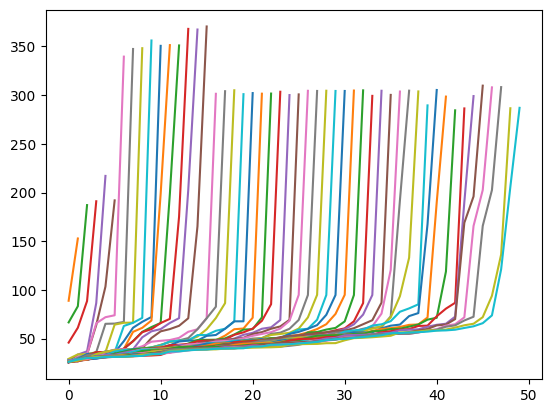

In [ ]:
for elem in mean_scores:
  plt.plot(list(sorted(elem)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



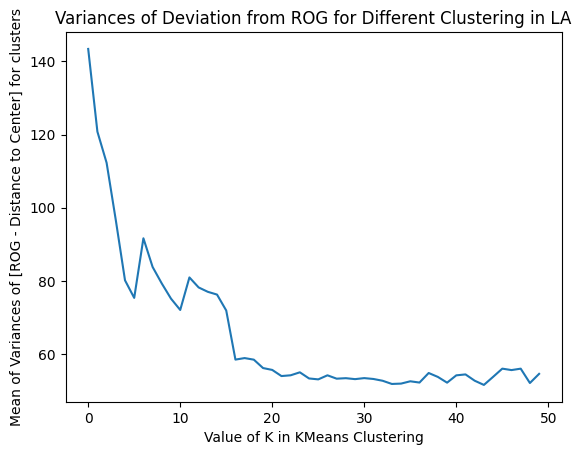

In [ ]:
result.sort(key = lambda x : x.n_clusters)
means = []
scores = [r.score for r in result]

for elem in mean_scores:
  means.append(np.mean(elem))


plt.plot(means)
plt.xlabel('Value of K in KMeans Clustering')
plt.ylabel('Mean of Variances of [ROG - Distance to Center] for clusters')
plt.title('Variances of Deviation from ROG for Different Clustering in LA')
plt.show()

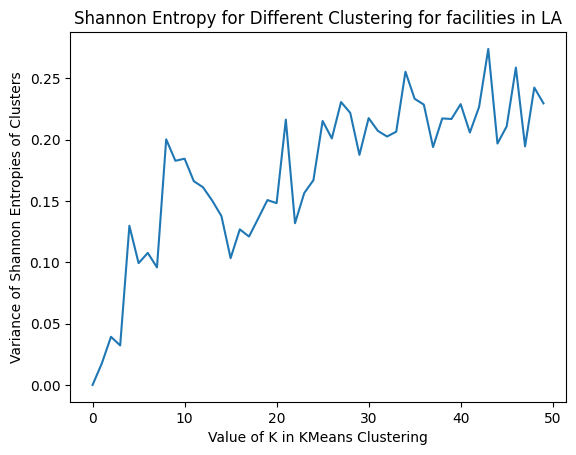

In [ ]:
plt.plot(scores)
plt.xlabel('Value of K in KMeans Clustering')
plt.ylabel('Variance of Shannon Entropies of Clusters')
plt.title('Shannon Entropy for Different Clustering for facilities in LA')
plt.show()

In [ ]:
OPT_K = 30

In [ ]:
opt_result = result[OPT_K - 1]

In [ ]:
opt_result.n_clusters

30

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
import numpy as np
import plotly.express as px

grouped = (opt_result.df).groupby('Label') # Group data by cluster labels

polygons = []
areas = []
densities = []
cardinalities = []
for label, group in grouped:
    points = group[['Longitude', 'Latitude']].values
    hull = ConvexHull(points)

    curr_area = hull.area
    areas.append(curr_area)

    curr_cardinality = group.shape[0]
    cardinalities.append(curr_cardinality)

    densities.append(curr_cardinality/curr_area)

    polygon_coords = [(points[i][0], points[i][1]) for i in hull.vertices]
    polygon = Polygon(polygon_coords)
    polygons.append({'Label': label, 'Polygon': polygon})

gdf = gpd.GeoDataFrame(polygons, geometry='Polygon') # GeoDataFrame from the polygons

fig = px.choropleth_mapbox(
    gdf,
    geojson=gdf.geometry,
    locations=gdf.index,
    color="Label",
    color_continuous_scale=px.colors.qualitative.Set1,
)

fig.update_geos(projection_type="mercator")
fig.update_layout(mapbox={"style": "open-street-map"})
fig.show()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_mo

In [ ]:
np.var(densities)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



1154197.4482645213

In [ ]:
np.var(areas)

0.0018294755918541574

In [ ]:
cardinalities.sort(reverse=True)
sum(cardinalities[:5])/sum(cardinalities[-5:])

4.112781954887218

In [ ]:
from pprint import pprint
import networkx as nx

with open("/content/la_35.txt") as f:
  content = f.read()

lines = content.split("\n")
#list(OPT_RESULT.centers[0][::-1])

edges = []
for line in lines:
  if line:
    nodes = line.split()
    start = int(nodes[0])
    start_center = list((opt_result.centers)[start][::-1]) #to get latitude first

    for i in range(1, len(nodes)):
      end = int(nodes[i])
      end_center = list((opt_result.centers)[end][::-1]) #to get latitude first
      dist = distance(start_center, end_center).km

      curr_tuple = (start, end, dist)

      if start != end:
        edges.append(curr_tuple)

pprint(edges)

G = nx.Graph()
for i in range(OPT_K):
  G.add_node(i)
G.add_weighted_edges_from(edges)


pprint(nx.betweenness_centrality(G))

nx.draw(G, with_labels = True)

FileNotFoundError: ignored

In [ ]:
curr_df = opt_result.df
curr_est = opt_result.estimator
curr_centers = opt_result.centers

#get labels for each rog point
rog_labels = curr_est.predict(rog_locs)

rogs = {}
all_rogs = []
for i in range(OPT_K):
  rogs[i] = []

#calculate distances
for i, pt in enumerate(rog_locs):
  curr_label = rog_labels[i]
  curr_center = curr_centers[curr_label]

  curr_rogs = rog_dict[pt[0]][pt[1]]
  rogs[curr_label].extend(curr_rogs)
  all_rogs.extend(curr_rogs)

In [ ]:
plt.hist(all_rogs, density=True, cumulative=True, label='CDF', histtype='step', alpha=0.8, color='k')

In [ ]:
plt.hist(all_rogs, density=True, cumulative=False, label='PDF', histtype='step', alpha=0.8, color='k')

In [ ]:
opt_centers = opt_result.centers

In [ ]:
opt_centers

array([[-118.24870101,   34.05055579],
       [-118.43984002,   34.06331044],
       [-118.13639074,   34.1468063 ],
       [-118.34243599,   33.97577704],
       [-118.08380088,   33.99038377],
       [-118.31393213,   34.18248924],
       [-118.33957966,   34.08865593],
       [-118.26956195,   33.96244378],
       [-118.43351009,   34.18429544],
       [-118.12597715,   34.08167658],
       [-118.39380792,   33.89377518],
       [-118.25229777,   34.14155974],
       [-118.18939489,   33.96458818],
       [-118.29955337,   34.04234307],
       [-118.3350731 ,   33.90044063],
       [-118.05897644,   34.1435012 ],
       [-118.39569683,   34.02021099],
       [-118.42557703,   33.98409703],
       [-118.20075328,   34.11091699],
       [-118.05972809,   33.91466499],
       [-118.39887865,   33.93822137],
       [-118.36642352,   34.15935525],
       [-118.38453262,   34.07491315],
       [-118.06423013,   34.08343443],
       [-118.21664121,   34.20395211],
       [-118.17271513,   

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(array([0.02058084, 0.02816325, 0.03737047, 0.04170327, 0.03357926,
        0.02924645, 0.02545524, 0.01299842, 0.00541601, 0.0010832 ]),
 array([ 3.22245825,  7.46700501, 11.71155178, 15.95609854, 20.20064531,
        24.44519208, 28.68973884, 32.93428561, 37.17883237, 41.42337914,
        45.6679259 ]),
 [<matplotlib.patches.Polygon at 0x794cf06d9810>])

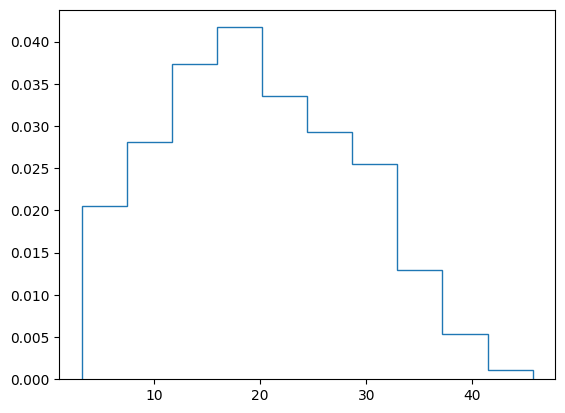

In [ ]:
center_dists = []
for i in range(len(opt_centers)):
  pt_i_formatted = list(opt_centers[i])[::-1]
  for j in range(i):
    pt_j_formatted = list(opt_centers[j])[::-1]
    curr_dist = distance(pt_i_formatted, pt_j_formatted).km
    center_dists.append(curr_dist)

plt.hist(center_dists, density=True, cumulative=False, label='CDF', histtype='step')

In [ ]:
np.mean(center_dists), np.var(center_dists)

(19.924463796971352, 78.46462760828985)

In [ ]:
min(center_dists)

3.2224582489374836